In [1]:
from __future__ import annotations
from typing import Optional
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools
import numpy as np

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

**Loading**

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [ ]:
# NOTE: donor 1037 is annoying. 
master[master['patient_id']==1037]

In [47]:
from util_funcs import do_basic_formatting
from util_funcs import do_basic_filtering
from util_funcs import format_regional_nodes_bins
from util_funcs import format_ln_status

print('\nBasic filtering')
df = do_basic_filtering(master)

HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
print('\nBasic formatting')
df = do_basic_formatting(df, HISTTYPES_PATH)

df = format_regional_nodes_bins(df)
df = format_ln_status(df)
df['ln_status'].value_counts(dropna=False)

df.head()


Basic filtering
Removing records not in range (2010, 2020)
- removed 371509 records
Selecting records with MALIGNANT behavior
- removed 632160 records
Handling patients with multiple records of same cancer_type
- removed 82397 records
Removing records where any met value (except distant LN) is missing
- removed 720503 records

Final records: 3798014, patients: 3597365

Basic formatting
Missing 0 codes.
Formatting cancer subtypes
TNG, Grade standardisation


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,any_met,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD,regional_nodes_prop,regnodes_exam_bin,regnodes_pos_bin,regnodes_prop_bin,ln_status
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.00,0.00,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NaN,NO,Infiltrating duct carcinoma [+ others],T3,N0,II,G3,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]",NaN
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,3.00,0.00,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,False,NO,Infiltrating duct carcinoma [+ others],T2,N0,II,G3,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]",neither
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,10.00,0.00,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,False,NO,Serous carcinoma [+ others],T1,N0,I,G2,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]",neither
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,0.00,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NO,Adenoma [+ others],T1,N0,II,G2,NaN,"(0, 10]",NaN,NaN,NaN
8,265,"2,016.00",2011,2016,65-69 years,Prostate,Prostate,Prostate,Prostate,T2c,N0,II,NaN,NaN,NaN,G3,NaN,NaN,0.00,NaN,MALIGNANT,2,0,7.70,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NO,Adenoma [+ others],T2,N0,II,G3,NaN,"(0, 10]",NaN,NaN,NaN


**Extra Filtering**

In [ ]:
# print('\nRemoving records for brain primaries')
# irecords = df.shape[0]
# df = df[df['cancer_type']!='Brain']
# print(f'removed {irecords - df.shape[0]} records')

# print('\nRemoving records for CNS cancer_group')
# irecords = df.shape[0]
# df = df[df['cancer_group']!='CNS']
# print(f'removed {irecords - df.shape[0]} records')

# df.head()

**T-stage**

In [48]:
import os 
from util_classes import Settings
from util_funcs import calculate_stats_grouped

In [71]:
from typing import Any

def _render_celltext_relrisk(rowlabels: list[str], collabels: list[str], s: Settings, table_colors: pd.DataFrame, table: pd.DataFrame, ax: Any):
    for y, rlabel in enumerate(rowlabels): 
        for x, clabel in enumerate(collabels): 
            # if y < 4:
            #     print(f'x={x}, y={y}, rlabel={rlabel}, clabel={clabel}')
            row = table.loc[(table[s.COMPOUND_GROUP]==rlabel) & (table[s.COMPOUND_FEATURE]==clabel)]
            if row.shape[0] == 0:
                normval, num_bm, num_cases = 0, 0, 0
            else:
                normval = row[s.RELRISK_FIELD].values[0]
                num_bm = row["YES"].values[0]
                num_cases = row["records"].values[0]
            line1 = f'{normval:0.2f}'
            line2 = f'{num_bm}/{num_cases}'
            color1 = table_colors.loc[rlabel, clabel]
            color2 = color1 if num_cases >= 500 else 'turquoise'
            ax.text(x+0.5, y+0.4, line1, va="center", ha="center", color=color1, fontsize='medium')
            ax.text(x+0.5, y+0.7, line2, va="center", ha="center", color=color2, fontsize='x-small')

def _render_celltext_cases(rowlabels: list[str], collabels: list[str], s: Settings, table_colors: pd.DataFrame, table: pd.DataFrame, ax: Any):
    for y, rlabel in enumerate(rowlabels): 
        for x, clabel in enumerate(collabels): 
            row = table.loc[(table[s.COMPOUND_GROUP]==rlabel) & (table[s.COMPOUND_FEATURE]==clabel)]
            if row.shape[0] == 0:
                num_mets, num_cases = 0, 0
            else:
                num_mets = row["YES"].values[0]
                num_cases = row["records"].values[0]
            line1 = f'{num_mets}'
            line2 = f'{num_cases}'
            basecolor = table_colors.loc[rlabel, clabel]
            color1 = basecolor if num_mets >= 5 else 'turquoise'
            color2 = basecolor if num_cases >= 1000 else 'turquoise'
            ax.text(x+0.5, y+0.4, line1, va="center", ha="center", color=color1, fontsize='medium')
            ax.text(x+0.5, y+0.7, line2, va="center", ha="center", color=color2, fontsize='x-small')


In [51]:
def calc_variability_table(brainmet_df: pd.DataFrame, othermets: list[pd.DataFrame], method: str='average_signal') -> pd.DataFrame:
    """
    how similar is brainmet table to othermet tables? 
    """

    # check that rows/cols have same order for all tables
    for othermet_df in othermets:
        assert brainmet_df.index.to_list() == othermet_df.index.to_list()
        assert brainmet_df.columns.to_list() == othermet_df.columns.to_list()
    
    # metric 1: compare brainmet to avg signal of other mets. 
    if method == 'average_signal':
        # sum other dfs
        temp_df = othermets[0]
        if len(othermets) > 1:
            for other_df in othermets[1:]:
                temp_df = temp_df.add(other_df)
        # take average
        temp_df = temp_df / len(othermets)
        # get abs difference between brain mets and other mets for each cell
        dist_df = (brainmet_df - temp_df).abs()

    # metric 2: compare brainmet to each other met. 
    elif method == 'average_linkage':
        dist_df = pd.DataFrame(data=0, columns=brainmet_df.columns, index=brainmet_df.index)
        for other_df in othermets:
            # get diff brainmet vs othermet
            absdiff_df = (brainmet_df - other_df).abs()
            # add to running cumulative diff
            dist_df = dist_df.add(absdiff_df)
        # take average
        dist_df = dist_df / len(othermets)
        
    # metric 3: compare brainmet to most similar other met. 
    elif method == 'single_linkage':
        mindists = (brainmet_df - othermets[0]).abs().to_numpy()
        if len(othermets) > 1:
            for other_df in othermets[1:]:
                dist_df = (brainmet_df - other_df).abs().to_numpy()
                mindists = np.minimum(mindists, dist_df)
        dist_df = pd.DataFrame(data=mindists, index=brainmet_df.index, columns=brainmet_df.columns)
    
    else:
        raise ValueError

    return dist_df # type: ignore
    

In [85]:
def generate_ordered_pivot_tables(tables: list[pd.DataFrame], s: Settings, valuefield: str) -> list[pd.DataFrame]:
        
    CLUSTER_GROUPS   = True
    CLUSTER_FEATURES = False
    
    # normalise prevalence & pivot for each table
    pivot_tables = []
    for table in tables:
        pivottable = table.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=valuefield)
        pivottable = pivottable.fillna(0)
        pivottable = pivottable.reindex(sorted(pivottable.columns), axis=1)
        Y = pivottable.to_numpy()
        tablemax = np.where(np.isinf(Y), -np.Inf, Y).max()
        X = np.where(np.isinf(Y), tablemax, Y)
        ptable = pd.DataFrame(data=X, index=pivottable.index, columns=pivottable.columns)
        pivot_tables.append(ptable)
    
    # plot clustermap for first table to allow clustering
    table1 = pivot_tables[0]
    cm = sns.clustermap(
        table1, 
        col_cluster=CLUSTER_FEATURES, 
        row_cluster=CLUSTER_GROUPS, 
        metric="correlation",
        square=True,
    )
    plt.plot()
    plt.close()

    # get row/col order from clustermap
    rowinds = cm.dendrogram_row.reordered_ind if CLUSTER_GROUPS else list(range(table1.shape[0]))
    colinds = cm.dendrogram_col.reordered_ind if CLUSTER_FEATURES else list(range(table1.shape[1]))
    rowlabels = [table1.index[idx] for idx in rowinds]
    collables = [table1.columns[idx] for idx in colinds]
    
    # reorder pivot table rows/cols using new ordering
    pivot_tables = [t[collables] for t in pivot_tables]
    pivot_tables = [t.loc[rowlabels] for t in pivot_tables]
    return pivot_tables

In [80]:

def calc_similarity_table(brainmet_df: pd.DataFrame, labels: list[str], othermets: list[pd.DataFrame], method: str='euclidean') -> pd.DataFrame:
    if method == 'correlation':
        assert len(labels) == len(othermets)
        master = pd.DataFrame(data=0, index=brainmet_df.index, columns=labels)
        for label, othermet_df in zip(labels, othermets):
            master[label] = brainmet_df.corrwith(othermet_df, axis=1)
        return master
    
    elif method == 'euclidean':
        master = pd.DataFrame(data=0, index=brainmet_df.index, columns=labels)
        rowlabels = master.index.to_list()
        
        def _euclidean_distance(row1, row2):
            return np.sqrt(np.sum([(a-b)**2 for a, b in zip(row1, row2)]))
        
        for mlabel, othermet_df in zip(labels, othermets):
            for rlabel in rowlabels:
                row1 = brainmet_df.loc[rlabel]
                row2 = othermet_df.loc[rlabel]
                dist = _euclidean_distance(row1, row2)
                # print(mlabel, rlabel)
                # print(row1)
                # print(row2)
                # print(dist)
                master.loc[rlabel, mlabel] = dist
        return master
    
    else:
        raise ValueError


In [10]:

def plot_profile_allmets_fmt2(
    groups: list[str],
    features: list[str], 
    tables: list[pd.DataFrame],
    pivot_tables: list[pd.DataFrame],
    labels: list[str],
    s: Settings,
    method: str,
    subdir_override: Optional[str]=None,
    ) -> None:
    assert labels[0] == 'brain_met'
    assert len(tables) == len(labels)

    # misc variables related to grid aesthetics 
    table1 = pivot_tables[0]
    max_table_value = table1.to_numpy().max()
    max_group_label_len = max([len(x) for x in table1.index])
    max_feature_label_len = max([len(x) for x in table1.columns])
    ncols = table1.shape[1]
    nrows = table1.shape[0]
    figy = nrows // 1.7 + max_feature_label_len // 8 + 2
    scale_factor = 0.6
    figx_ax1 = 6*scale_factor
    figx_ax2 = 4*scale_factor
    figx_ax3 = 3*scale_factor
    
    # subplot for each met type (single row)
    fig, axes = plt.subplots(
        nrows=1, ncols=3, 
        figsize=(figx_ax1 + figx_ax2 + figx_ax3 + max_group_label_len // 10, figy),
        width_ratios=[6, 4, 3]
    )
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    
    # FIGURE 1 #
    # brain met profile as heatmap (using the row/col ordering from clustermap)
    bm_table = tables[0]
    bm_table_p = pivot_tables[0]
    sns.heatmap(bm_table_p, cbar=False, ax=ax1)
    rowlabels = pivot_tables[0].index.to_list()
    collables = pivot_tables[0].columns.to_list()
    _render_celltext_relrisk(rowlabels, collables, s, max_table_value, bm_table, ax=ax1)
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    met_labels = '_'.join(labels).replace('_met', '')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_title('Brain Met Profile')

    # FIGURE 2 #
    # which cells have different values in other mets?
    dist_df = calc_variability_table(brainmet_df=bm_table_p, othermets=pivot_tables[1:], method=method)
    sns.heatmap(dist_df, annot=True, cmap='YlGnBu', cbar=False, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_title('Feature Variability')
    
    # FIGURE 3 #
    # Which other mets have different profiles to brain? 
    corr_df = calc_similarity_table(brainmet_df=bm_table_p, labels=labels[1:], othermets=pivot_tables[1:])
    sns.heatmap(corr_df, annot=True, cmap='YlOrRd_r', cbar=False, ax=ax3)
    ax3.set_ylabel('')
    ax3.set_yticks([])
    ax3.set_yticklabels([])
    ax3.set_title('Correlation')

    # saving
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{subdir_override}/{group_lab}_{feature_lab}_fmt2.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{group_lab}/{feature_lab}_fmt2.png'

    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    title = f'{group_lab} vs {feature_lab}'
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)

In [81]:
def plot_profile_allmets_fmt1(
    groups: list[str],
    features: list[str], 
    tables: list[pd.DataFrame],
    pivot_tables: list[pd.DataFrame],
    labels: list[str],
    s: Settings,
    cmap: Any, 
    metsim_method: str,
    subdir_override: Optional[str]=None,
    extra_label: Optional[str]=None
    ) -> None:
    assert labels[0] == 'brain_met'
    assert len(tables) == len(labels)
    ntables = len(tables)

    # misc variables related to grid aesthetics 
    table1 = pivot_tables[0]
    rowlabels = table1.index.to_list()
    collables = table1.columns.to_list()
    maxval = max([t.to_numpy().max() for t in pivot_tables]) * 2
    max_group_label_len = max([len(x) for x in table1.index])
    max_feature_label_len = max([len(x) for x in table1.columns])
    ncols = table1.shape[1]
    nrows = table1.shape[0]
    figx = ncols
    figy = nrows // 1.7 + max_feature_label_len // 8 + 2
    
    # subplot for each met type (single row)
    fig, axes = plt.subplots(
        nrows=1, ncols=ntables + 1, 
        figsize=(figx*ntables + max_group_label_len / 8, figy),
    )
    
    # plot profiles as heatmaps for all tables using the row/col ordering from clustermap
    i = 0
    for table, table_p, label in zip(tables, pivot_tables, labels):
        # specify target axes
        ax = axes[i]
        # render heatmap
        sns.heatmap(table_p, cmap=cmap, cbar=False, ax=ax, vmax=maxval)
        # render text
        thresh = 0.7 * maxval
        table_colors = pd.DataFrame('black', index=table_p.index, columns=table_p.columns)
        table_colors = table_colors.mask(table_p >= thresh, 'white')
        print(table_colors.head())
        _render_celltext_cases(rowlabels, collables, s, table_colors, table, ax=ax)
        # _render_celltext_relrisk(rowlabels, collables, s, table_colors, table, ax=ax)
        ax.set_title(label)
        ax.set_ylabel('')
        if i >= 1:
            ax.set_yticks([])
            ax.set_yticklabels([])
        i += 1

    # final heatmap: brainmet profile vs othermet profile.
    ax5 = axes[4]
    corr_df = calc_similarity_table(brainmet_df=pivot_tables[0], labels=labels[1:], othermets=pivot_tables[1:], method=metsim_method)
    sns.heatmap(corr_df, annot=True, cmap='YlOrRd', cbar=False, ax=ax5)
    ax5.set_ylabel('')
    ax5.set_yticks([])
    ax5.set_yticklabels([])
    ax5.set_title('Dissimilarity')

    # titles & saving
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    met_labels = '_'.join(labels).replace('_met', '')
    suffix = f'_{extra_label}' if extra_label else ''
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{subdir_override}/{group_lab}_{feature_lab}_fmt1_{metsim_method}{suffix}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{group_lab}/{feature_lab}_fmt1_{metsim_method}{suffix}.png'

    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    title = f'{group_lab} vs {feature_lab}'
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)



--- One group, one feature ---
Running profile for all mets with following settings: ---
Groups: ['cancer_group']
Fields: ['TSTAGE_STD']
Groups subset: None
Features subset: {'ln_status': ['loco', 'both']}

Response: "brain_met"
38/41 subsets calculated
Removed 13/41 groups

Response: "bone_met"
38/41 subsets calculated
Removed 8/41 groups

Response: "lung_met"
38/41 subsets calculated
Removed 7/41 groups

Response: "liver_met"
38/41 subsets calculated
Removed 8/41 groups
Removing exclusive groups
Pivots
  derived_feature      NO  YES  records  prevalence (%)  relrisk OR_STAT OR_CI_LOW OR_CI_HIGH derived_group
0              T1  368049  259   368308            0.07     0.02   -1.50     -1.63      -1.37        Breast
1              T2  189684  579   190263            0.30     0.07   -0.03     -0.13       0.06        Breast
2              T3   38485  321    38806            0.83     0.19    0.97      0.85       1.09        Breast
3              T4   25474  802    26276            3.05 

ValueError: The condensed distance matrix must contain only finite values.

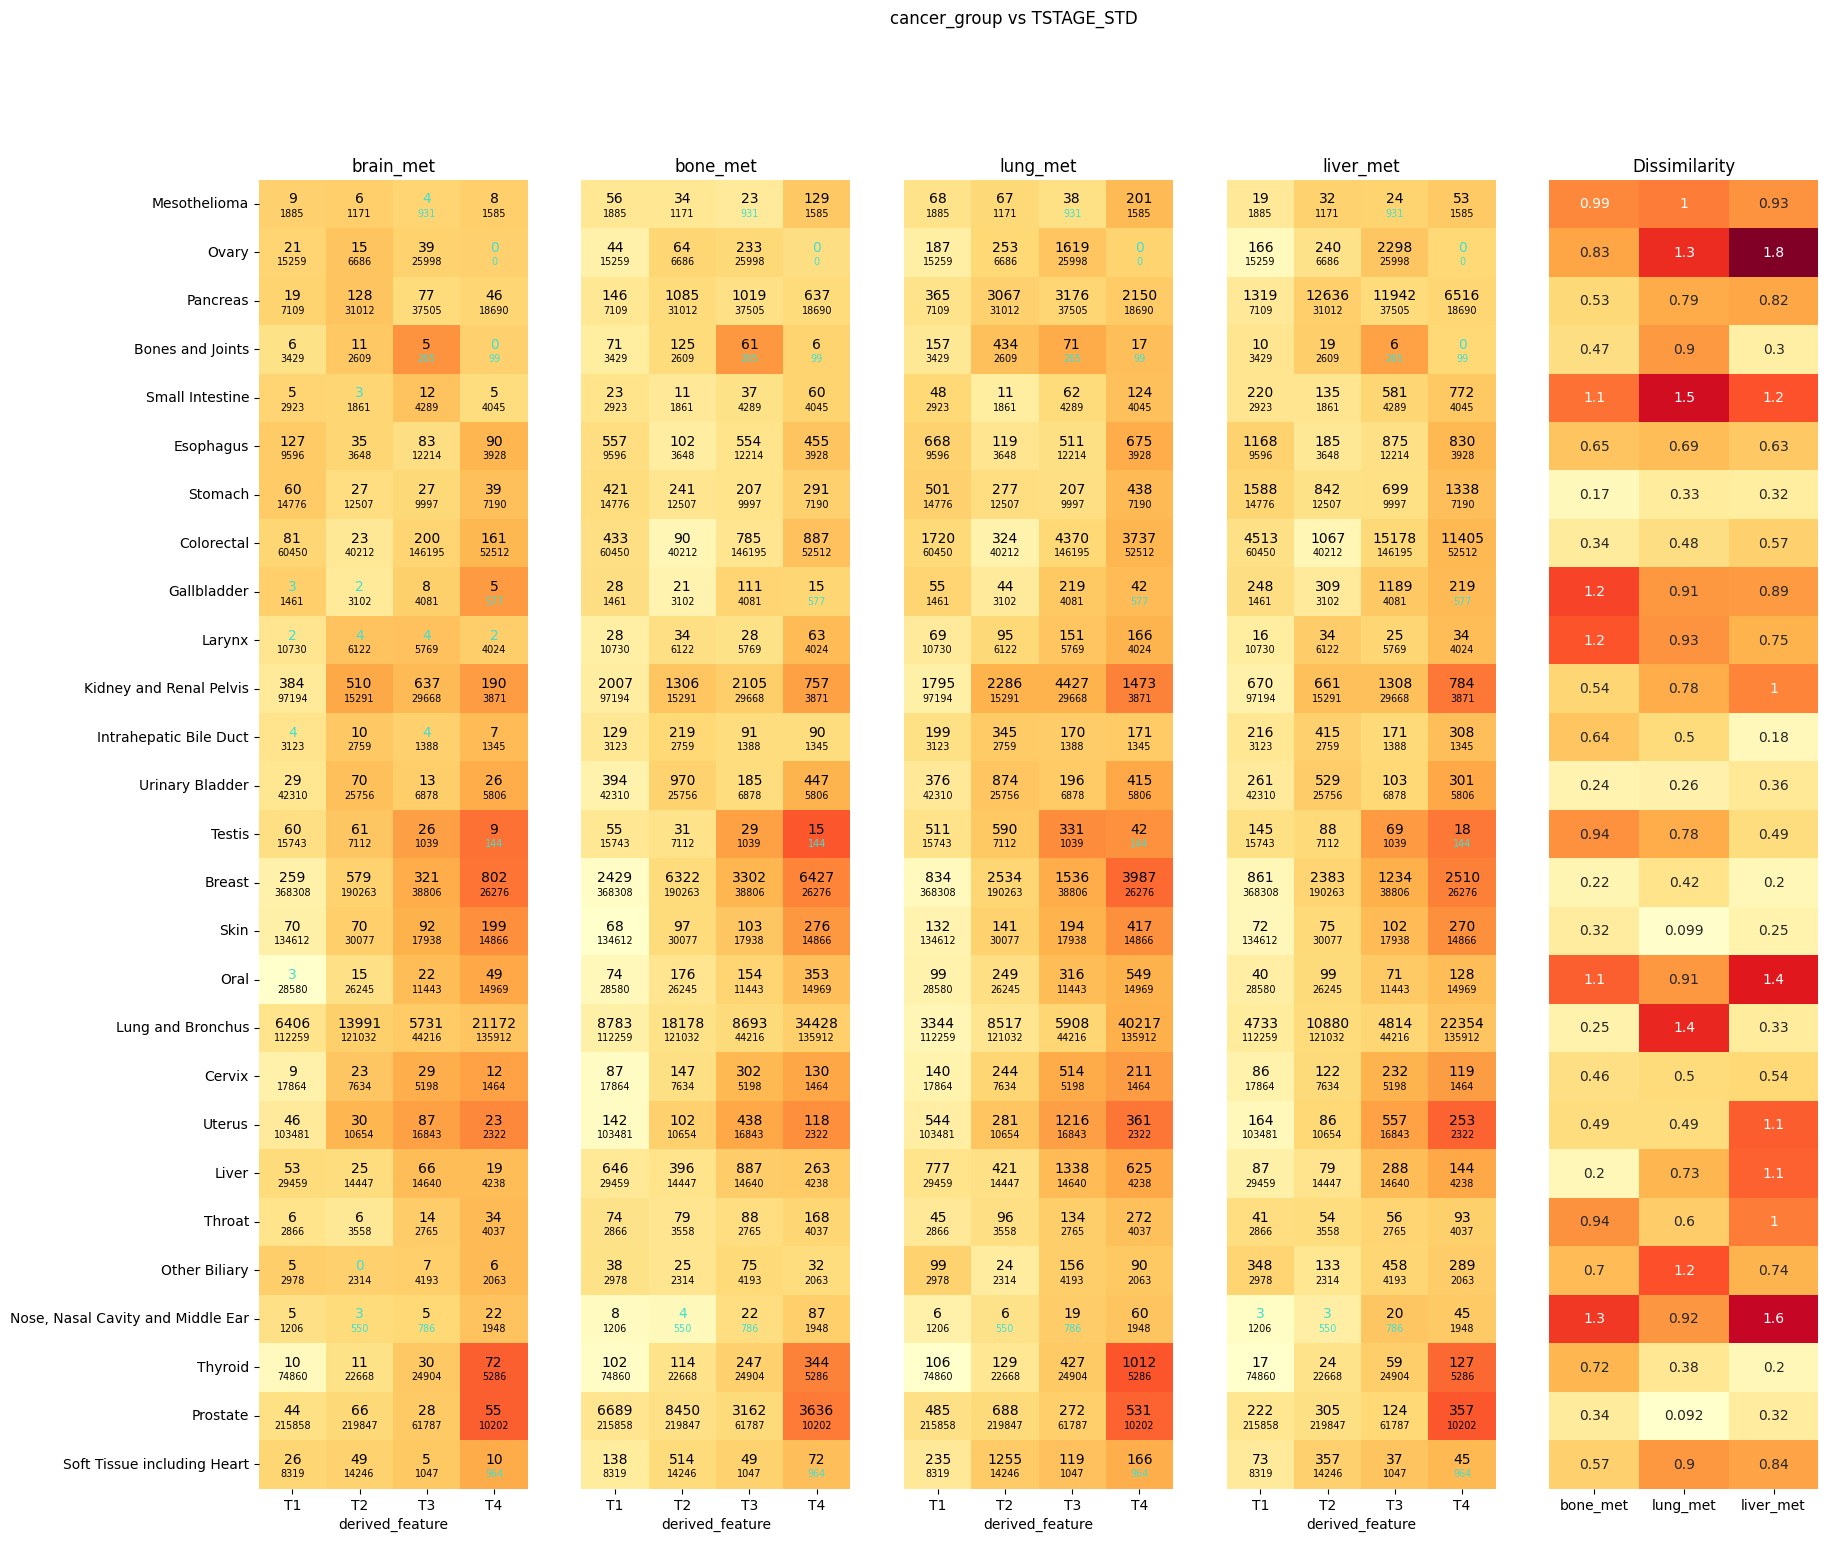

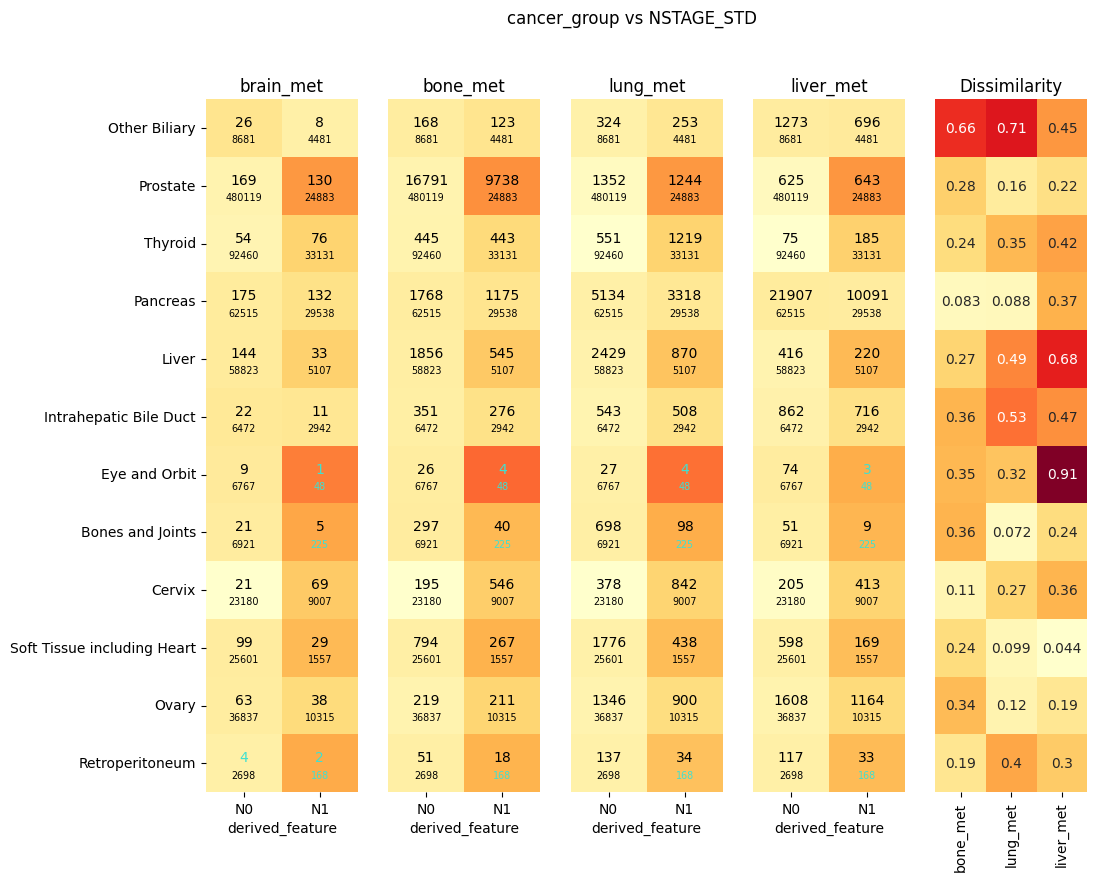

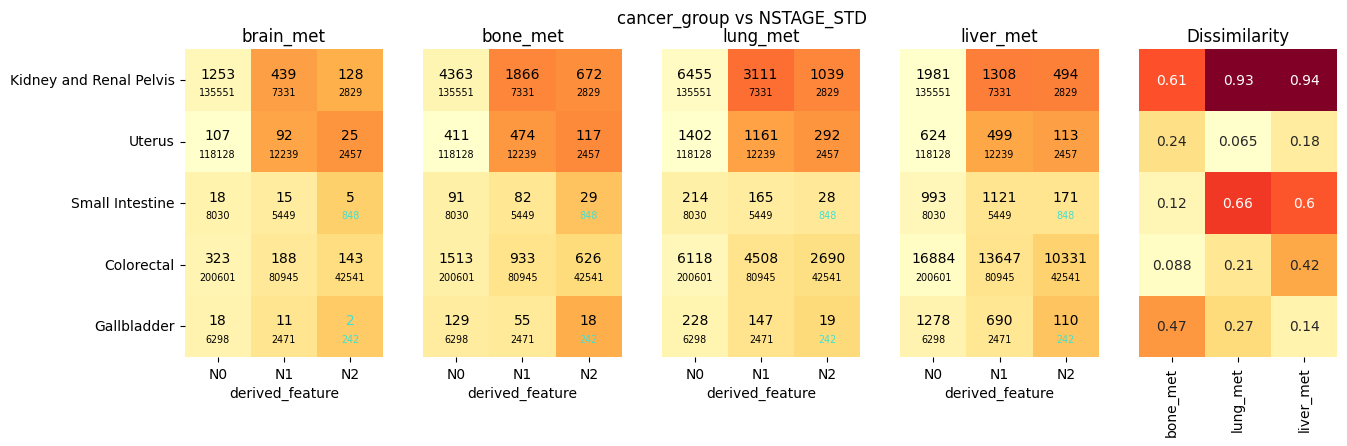

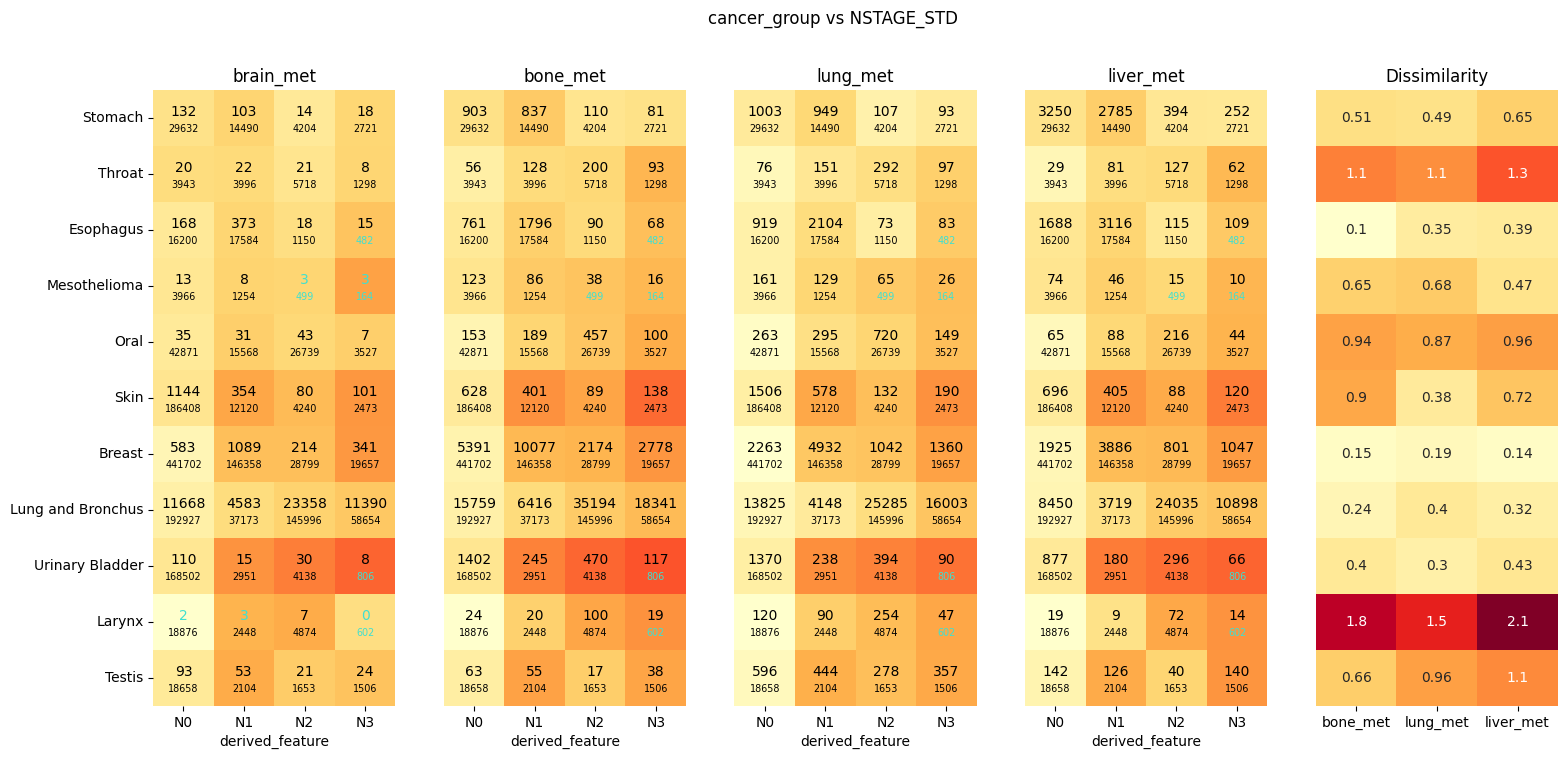

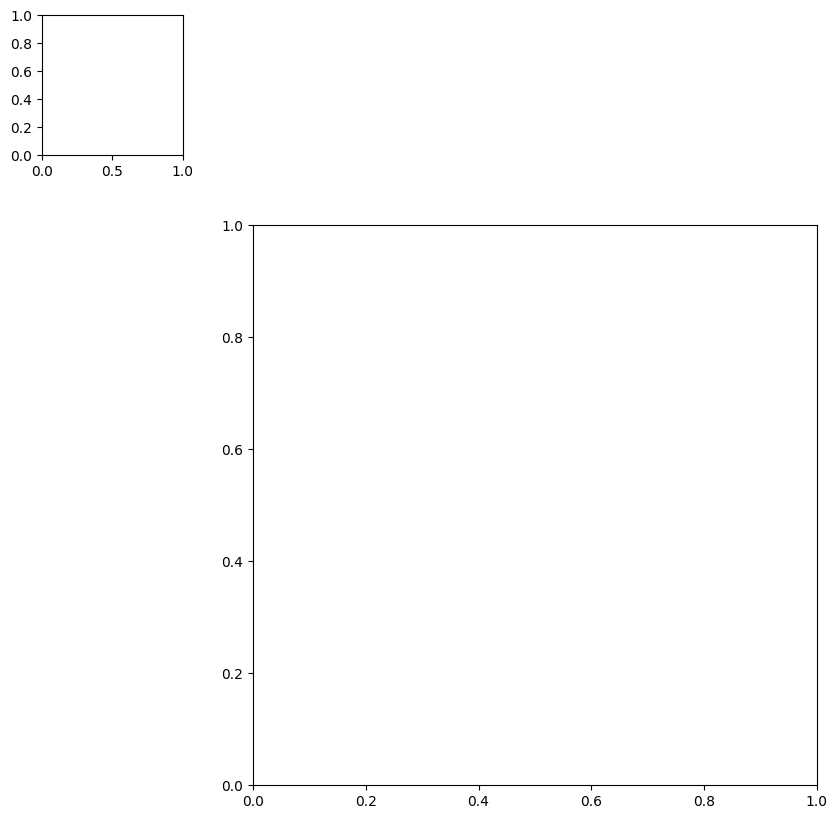

In [86]:

from util_funcs import calculate_stats_grouped

def do_profile_allmets(
    groups: list[str],
    features: list[str],
    response_fields: list[str],
    s: Settings,
    df: pd.DataFrame,
    measure: str='logodds',
    groups_subset: Optional[dict]=None,
    features_subset: Optional[dict]=None,
    extra_label: Optional[str]=None
) -> None:
    
    print('Running profile for all mets with following settings: ---')
    print(f'Groups: {gfields}')
    print(f'Fields: {ffields}')
    print(f'Groups subset: {groups_subset}')
    print(f'Features subset: {features_subset}')
    
    tables = []
    # calculate prevalence table for each met type
    for res in response_fields:
        print(f'\nResponse: "{res}"')
        maintable = calculate_stats_grouped(
            groups=groups, 
            features=features, 
            response_field=res,
            s=s,
            groups_subset=groups_subset,
            features_subset=features_subset,
            df=df
        )
        tables.append(maintable)
    
    print('Removing exclusive groups')
    filt_tables = remove_exclusive_groups(tables)

    print('Pivots')
    if measure == 'logodds':
        # cmap = sns.color_palette("rocket_r", as_cmap=True)
        cmap = 'YlOrRd'
        valuefield = s.OR_STAT
    elif measure == 'relrisk':
        cmap = 'YlOrRd'
        valuefield = s.RELRISK_FIELD
    else:
        raise ValueError
    pivot_tables = generate_ordered_pivot_tables(filt_tables, s, valuefield)

    print(tables[0].head())
    print()
    print(pivot_tables[0].head())
    print()
    print('Plotting')
    plot_profile_allmets_fmt1(
        groups=gfields, 
        features=ffields, 
        tables=filt_tables,
        pivot_tables=pivot_tables, 
        labels=response_fields,
        s=s,
        cmap=cmap,
        metsim_method='euclidean',
        extra_label=extra_label
    )

from util_maps import CGROUPS_NSTAGES_N0N1
from util_maps import CGROUPS_NSTAGES_N0N1N2
from util_maps import CGROUPS_NSTAGES_N0N1N2N3

s = Settings()
groups = ['cancer_group', 'hist_type_descr']
# groups = ['hist_type_descr']
# features = ['TSTAGE_STD']
features = ['TSTAGE_STD', 'NSTAGE_STD', 'GRADE_STD', 'ln_status', 'regnodes_prop_bin']
# features = ['ln_status', 'regnodes_prop_bin']
groups_subset = None
features_subset = None
response_fields = ['brain_met', 'bone_met', 'lung_met', 'liver_met']

# test_classes = ['Prostate', 'Breast', 'Skin', 'Lung and Bronchus']
# temp = df[df['cancer_group'].isin(test_classes)]

print('\n\n--- One group, one feature ---')
for gfield in groups:
    for ffield in features:
        gfields = [gfield]
        ffields = [ffield]
        # features_subset = {'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}
        features_subset = {'ln_status': ['loco', 'both']}

        # cancer_group or cancer_type must be used with NSTAGE as N staging is cancer dependent. 
        if ffield == 'NSTAGE_STD' and gfield not in ['cancer_group', 'cancer_type']:
            continue 
        
        if ffield == 'NSTAGE_STD':
            labels = ['N0N1', 'N0N1N2', 'N0N1N2N3']
            gsubsets = [CGROUPS_NSTAGES_N0N1, CGROUPS_NSTAGES_N0N1N2, CGROUPS_NSTAGES_N0N1N2N3]
            fsubsets = [
                ['N0', 'N1'],
                ['N0', 'N1', 'N2'],
                ['N0', 'N1', 'N2', 'N3'],
            ]
            for label, gsubset, fsubset in zip(labels, gsubsets, fsubsets):
                do_profile_allmets(
                    groups=gfields,
                    features=ffields,
                    response_fields=response_fields,
                    s=s,
                    df=df,
                    groups_subset={gfield: gsubset},
                    features_subset={ffield: fsubset},
                    extra_label=label
                )
        
        else:
            do_profile_allmets(
                groups=gfields,
                features=ffields,
                response_fields=response_fields,
                s=s,
                df=df,
                groups_subset=None,
                features_subset=features_subset,
                extra_label=None
            )
        

In [ ]:
df = pd.DataFrame(np.arange(10).reshape(-1, 2), columns=['A', 'B'])
temp = pd.DataFrame('white', index=df.index, columns=df.columns)
print(df)
print(temp)
temp = temp.mask(df > 3, 'black')
temp

/home/grace/work/SEER/outputs/clustermaps_allmets/brain_bone_lung_liver/cancer_group/GRADE_STD_average_linkage.png


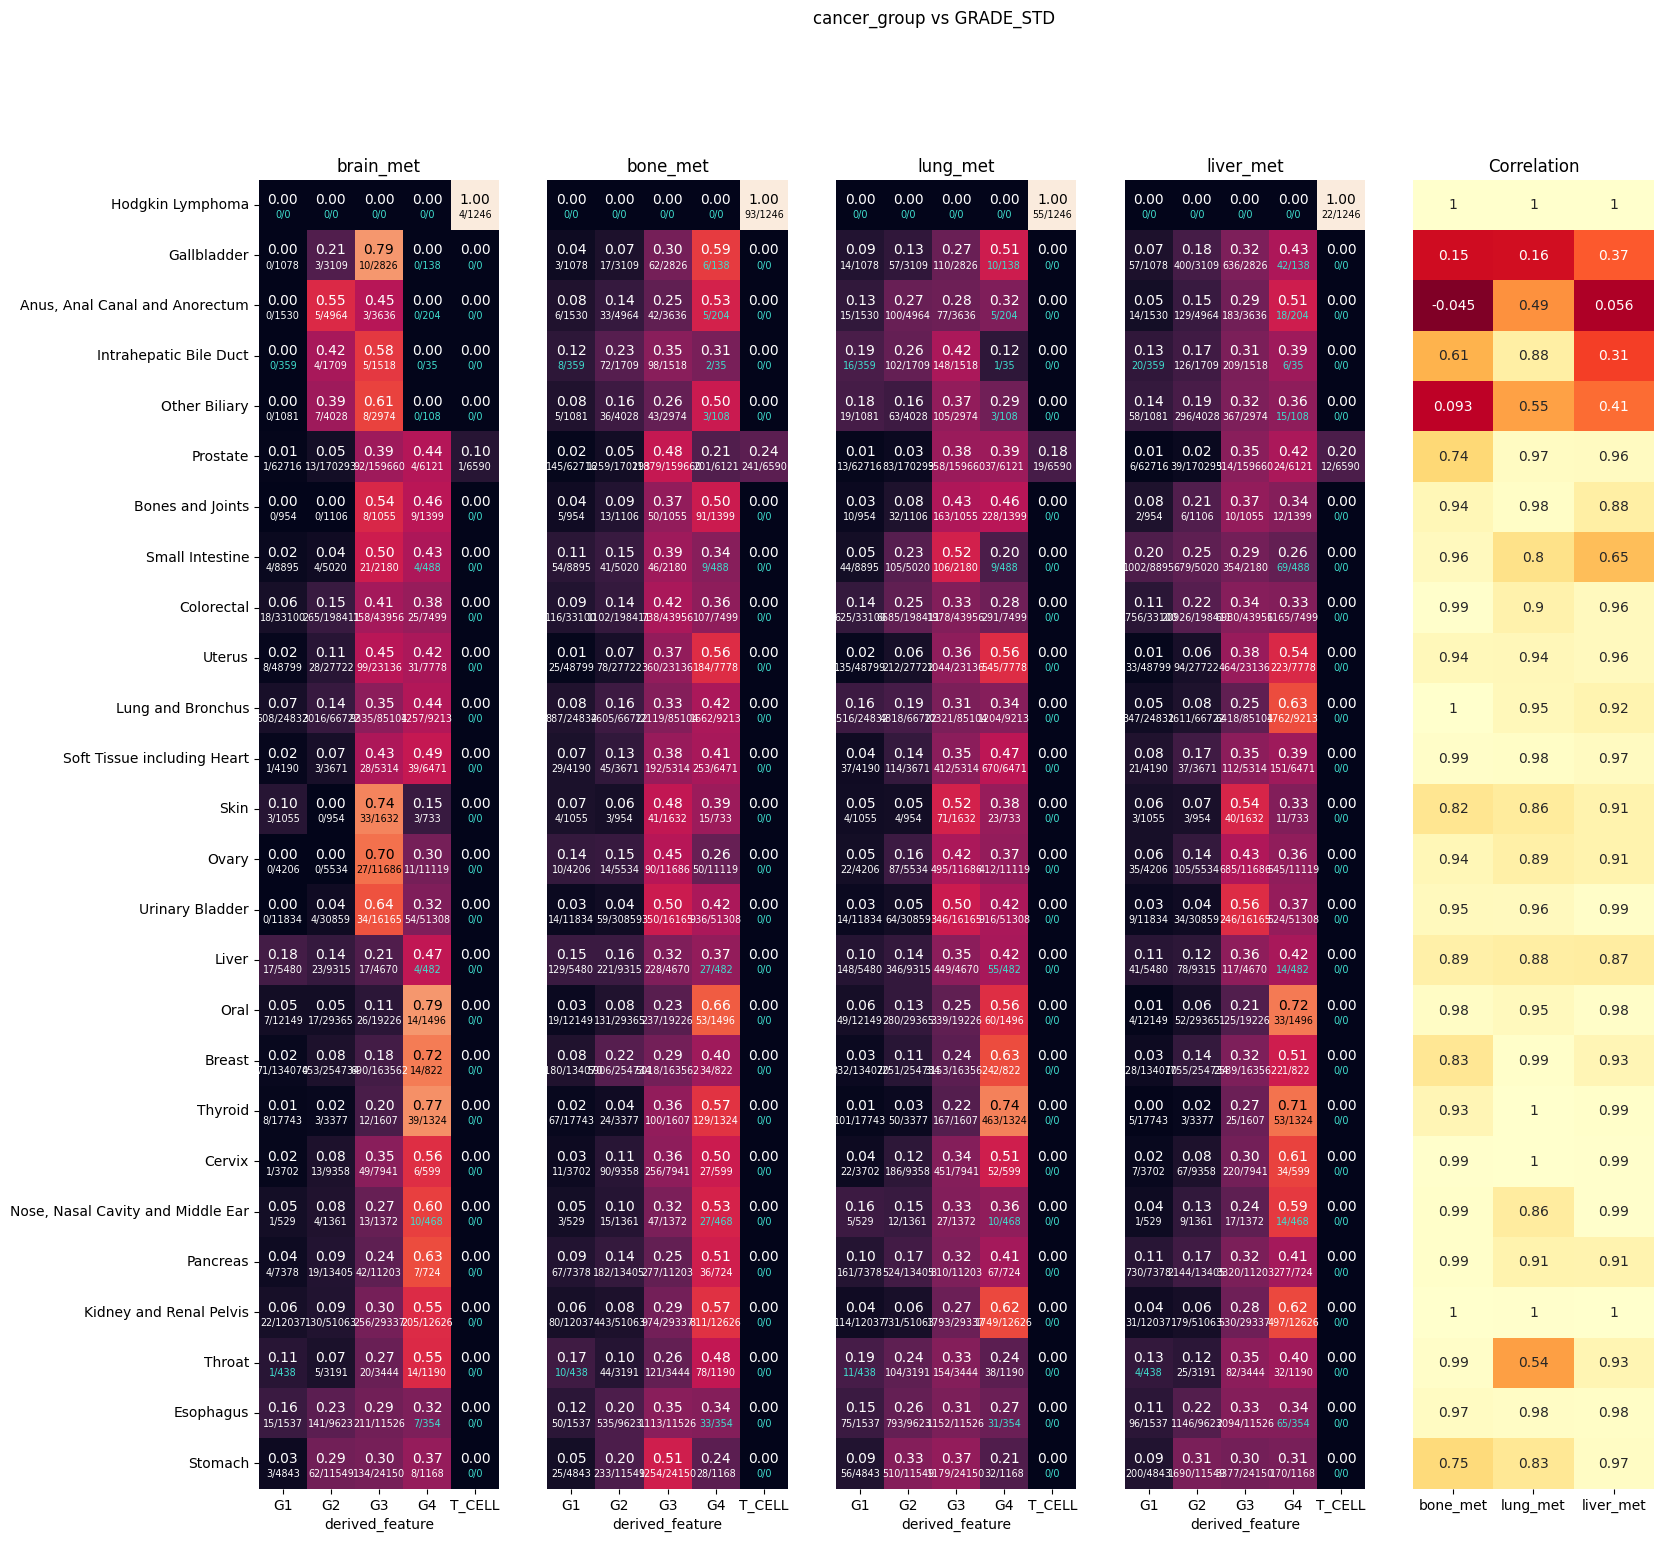

In [173]:
plot_profile_allmets_fmt1(
    groups=gfields, 
    features=ffields, 
    tables=filt_tables,
    pivot_tables=pivot_tables, 
    labels=response_fields,
    s=s,
    metsim_method='average_linkage'
)

In [ ]:
# print(pivot_tables[0].head())
corr = pivot_tables[0].T.corr()
# corr = corr[reversed(corr.columns.to_list())]
# corr = corr.loc[reversed(corr.index.to_list())]
print(corr.shape)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax)

In [ ]:
from collections import defaultdict
import scipy

def plot_profile_allmets(
    groups: list[str],
    features: list[str], 
    tables: list[pd.DataFrame],
    labels: list[str],
    s: Settings,
    method: str,
    subdir_override: Optional[str]=None,
    ) -> None:
    assert labels[0] == 'brain_met'
    assert len(tables) == len(labels)
    
    CLUSTER_GROUPS   = True
    CLUSTER_FEATURES = False

    ntables = len(tables)
    
    # normalise prevalence & pivot for each table
    pivot_tables = []
    for table in tables:
        pivottable = table.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.RELRISK_FIELD)
        pivottable = pivottable.fillna(0)
        pivottable = pivottable.reindex(sorted(pivottable.columns), axis=1)
        pivot_tables.append(pivottable)

    # plot clustermap for first table to allow clustering
    table1 = pivot_tables[0]
    cm = sns.clustermap(
        table1, 
        col_cluster=CLUSTER_FEATURES, 
        row_cluster=CLUSTER_GROUPS, 
        metric="correlation",
        square=True,
    )
    plt.plot()
    plt.close()

    # get row/col order from clustermap
    rowinds = cm.dendrogram_row.reordered_ind if CLUSTER_GROUPS else list(range(table1.shape[0]))
    colinds = cm.dendrogram_col.reordered_ind if CLUSTER_FEATURES else list(range(table1.shape[1]))
    rowlabels = [table1.index[idx] for idx in rowinds]
    collables = [table1.columns[idx] for idx in colinds]
    
    # reorder pivot table rows/cols using new ordering
    pivot_tables = [t[collables] for t in pivot_tables]
    pivot_tables = [t.loc[rowlabels] for t in pivot_tables]

    # misc variables related to grid aesthetics 
    max_table_value = table1.to_numpy().max()
    max_group_label_len = max([len(x) for x in table1.index])
    max_feature_label_len = max([len(x) for x in table1.columns])
    ncols = table1.shape[1]
    nrows = table1.shape[0]
    figx = ncols // 2 + 1
    figy = nrows // 1.7 + max_feature_label_len // 8 + 2
    
    # subplot for each met type (single row)
    fig, axes = plt.subplots(
        nrows=1, ncols=ntables + 1, 
        figsize=(figx*ntables + max_group_label_len // 8 + 1, figy),
    )
    
    # plot profiles as heatmaps for all tables using the row/col ordering from clustermap
    i = 0
    for table, table_p, label in zip(tables, pivot_tables, labels):

        # # reorder rows & cols correct conformation
        # table_p = table_p[collables]
        # table_p = table_p.loc[rowlabels]

        # print(f'\n\n---- {i}: {label} ----')
        # print(table_p.head())

        # specify target axes
        ax = axes[i]
        # render heatmap
        sns.heatmap(table_p, cbar=False, ax=ax)
        # render text
        _render_celltext_relrisk(rowlabels, collables, s, max_table_value, table, ax=ax)
        ax.set_title(label)
        ax.set_ylabel('')
        if i >= 1:
            ax.set_yticks([])
            ax.set_yticklabels([])
        i += 1

    # final heatmap: brainmet profile vs othermet profile.
    dist_df = calc_variability_table(brainmet_df=pivot_tables[0], othermets=pivot_tables[1:], method=method)
    
    # # reorder rows & cols correct conformation
    # dist_df = dist_df[collables]
    # dist_df = dist_df.loc[rowlabels]

    ax5 = axes[4]
    sns.heatmap(dist_df, annot=True, cmap='PiYG_r', cbar=False, ax=ax5)
    ax5.set_ylabel('')
    ax5.set_yticks([])
    ax5.set_yticklabels([])
    ax5.set_xticks([])
    ax5.set_xticklabels([])
    ax5.set_title('Distance\n(Brain mets vs other mets)')

    # titles & saving
    group_lab = ':'.join(groups)
    feature_lab = ':'.join(features)
    met_labels = '_'.join(labels).replace('_met', '')
    if subdir_override:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{subdir_override}/{group_lab}_{feature_lab}_{method}.png'
    else:
        filepath = f'/home/grace/work/SEER/outputs/clustermaps_allmets/{met_labels}/{group_lab}/{feature_lab}_{method}.png'

    os.makedirs(filepath.rsplit('/', 1)[0], exist_ok=True)
    title = f'{group_lab} vs {feature_lab}'
    cm.ax_heatmap.set_xlabel(feature_lab)
    cm.ax_heatmap.set_ylabel(group_lab)
    plt.suptitle(title)
    plt.savefig(filepath)
    print(filepath)

In [ ]:

def do_clustermap(
    groups: list[str],
    features: list[str], 
    response_fields: list[str],
    df: pd.DataFrame, 
    s: Settings,
    groups_subset: Optional[dict]=None, 
    features_subset: Optional[dict]=None,
    subdir_override: Optional[str]=None,
    ) -> None:
        
    print(f'Groups: {":".join(groups)}    Features: {":".join(features)}    Responses: {":".join(response_fields)}')

    pivot_tables = []
    pivot_labels = []

    for field in response_fields:
        # calculate prevalence per group
        maintable = calculate_stats_grouped(
            groups=groups, 
            features=features, 
            response_field=field,
            s=s,
            groups_subset=groups_subset,
            features_subset=features_subset,
            df=df
        )
        
        # pivot
        maintable_p = maintable.pivot(index=s.COMPOUND_GROUP, columns=s.COMPOUND_FEATURE, values=s.RELRISK_FIELD)
        maintable_p = maintable_p.fillna(0)
        maintable_p = maintable_p.reindex(sorted(maintable_p.columns), axis=1)
        pivot_tables.append(maintable_p)
        pivot_labels.append(field)

    plot_clustmap(
        groups=groups,
        features=features,
        pivot_tables=pivot_tables,
        pivot_labels=pivot_labels,
        s=s,
        subdir_override=subdir_override
    )


In [ ]:

def do_all_clustermaps(
    group_fields: list[str], 
    feature_fields: list[str], 
    response_field: str,
    s: Settings,
    df: pd.DataFrame, 
    subdir_override: Optional[str]=None) -> None:
    # single group vs single feature
    print('\nOne group, one feature')
    min_records = 1000
    for gfield in group_fields:
        for ffield in feature_fields:
            gfields = [gfield]
            ffields = [ffield]
            plot_clustmap(
                groups=gfields, 
                features=ffields, 
                response_field=response_field, 
                min_records=min_records, 
                df=df, 
                s=s, 
                features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
            )

    # single group vs two features
    if len(feature_fields) > 1:
        print('\nOne group, two features')
        min_records = 5000
        for gfield in group_fields:
            for ffields in itertools.combinations(feature_fields, 2):
                gfields = [gfield]
                ffields = list(ffields)
                plot_clustmap(
                    groups=gfields, 
                    features=ffields, 
                    response_field=response_field, 
                    min_records=min_records, 
                    df=df, 
                    s=s, 
                    features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
                )

    # two groups vs single feature
    if len(group_fields) > 1:
        print('\nTwo groups, single feature')
        min_records = 1000
        for ffield in feature_fields:
            ffields = [ffield]
            plot_clustmap(
                groups=group_fields, 
                features=ffields, 
                response_field=response_field, 
                min_records=min_records, 
                df=df, 
                s=s, 
                features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
            )
        # two groups vs two features
        if len(feature_fields) > 1:
            print('\nTwo groups, two features')
            min_records = 5000
            for ffields in itertools.combinations(feature_fields, 2):
                ffields = list(ffields)
                plot_clustmap(
                    groups=group_fields, 
                    features=ffields, 
                    response_field=response_field, 
                    min_records=min_records, 
                    df=df, 
                    s=s, 
                    features_subset={'GRADE_STD': ['G1', 'G2', 'G3', 'G4']}, subdir_override=subdir_override
                )


In [ ]:

settings = Settings()
RESPONSE_FIELD = 'brain_met'

###############
### GENERAL ###
###############
print('\n\n--- GENERAL ---\n')
do_all_clustermaps(
    group_fields=['cancer_group', 'hist_cateogry'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=df
)

##############
### BREAST ###
##############
print('\n\n--- BREAST ---\n')
breast_df = df[df['cancer_group']=='Breast']

do_all_clustermaps(
    group_fields=['breast_subtype', 'hist_cateogry'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=breast_df,
    subdir_override='breast'
)

################
### PROSTATE ###
################
print('\n\n--- PROSTATE ---\n')
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
prostate_df = df[df['cancer_group']=='Prostate']
prostate_df['psa_bin'] = pd.cut(prostate_df['psa'], bins).astype(str)

# PSA value to bins
do_all_clustermaps(
    group_fields=['hist_cateogry', 'hist_type_descr'], 
    feature_fields=['psa_bin'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=prostate_df,
    subdir_override='prostate'
)
do_all_clustermaps(
    group_fields=['psa_bin'], 
    feature_fields=['GRADE_STD', 'NSTAGE_STD', 'TSTAGE_STD'], 
    response_field=RESPONSE_FIELD,
    s=settings,
    df=prostate_df,
    subdir_override='prostate'
)


In [ ]:
NSTAGE_IGNORES = [
    'NHL - Extranodal', 
    'NHL - Nodal', 
    'Hodgkin - Extranodal', 
    'Hodgkin - Nodal'
]
N0N1_OVERRIDES = ['Pancreas', 'Other Biliary']


<br>
<br>
<br>
<br>
<br>
<br>
<br>